# Universidad de Buenos Aires
# Procesamiento de Lenguaje Natural - Desafio: 3
# Alumno: Matias Werbin



## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
!pip install keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found exis

In [ ]:
# importación de librerías
import random
import io
import pickle
import os
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout,GRU, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
import os

# Ruta del directorio de los archivos de entrenamiento
corpus_path = 'Corpus'

# Lista para almacenar todos los textos
texts = []

# Leer cada archivo y almacenar su contenido en la lista
for filename in os.listdir(corpus_path):
    if filename.endswith(".txt"):
        with open(os.path.join(corpus_path, filename), 'r', encoding='utf-8') as file:
            content = file.read().strip()  # Leer el contenido y eliminar espacios en blanco al inicio y al final
            texts.append(content)

# Concatenar todos los textos con saltos de línea entre ellos
combined_text = "\n".join(texts)

# Escribir en un solo archivo el Corpus concatenado
output_file = 'combined_text.txt'
with open(output_file, 'w', encoding='utf-8') as file:
    file.write(combined_text)

print(f"Se ha combinado el contenido de los archivos en '{output_file}'")


Se ha combinado el contenido de los archivos en 'combined_text.txt'


In [ ]:
# Armado de df mediante saltos de linea. Cada oración es un documento
df = pd.read_csv('/content/combined_text.txt', sep='/n', header=None)
df.head()

<ipython-input-13-b924c6f47521>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/combined_text.txt', sep='/n', header=None)


,0
0,Los Vengadores son un grupo de los héroes más ...
1,La primera alineación de los Vengadores incluy...
2,La batalla de Nueva York fue el primer gran de...
3,"A lo largo de los años, los Vengadores han enf..."
4,La Saga del Infinito fue quizás el mayor desaf...


In [ ]:
print(f"Cantidad de documentos en el Corpus: {df.shape[0]}")

Cantidad de documentos en el Corpus: 32


In [ ]:
# Guardamos cada secuencia en una lista
secs=list(df.loc[:,0])

# verifamamos tener 32 secuencias
len(secs)

32

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

segmented_sec=[text_to_word_sequence(sec) for sec in secs]

In [ ]:
length_doc = [len(sec) for sec in segmented_sec]

(array([3., 2., 4., 1., 2., 3., 3., 2., 3., 1., 1., 3., 0., 0., 1., 1., 1.,
        0., 0., 1.]),
 array([ 61.  ,  63.15,  65.3 ,  67.45,  69.6 ,  71.75,  73.9 ,  76.05,
         78.2 ,  80.35,  82.5 ,  84.65,  86.8 ,  88.95,  91.1 ,  93.25,
         95.4 ,  97.55,  99.7 , 101.85, 104.  ]),
 <BarContainer object of 20 artists>)

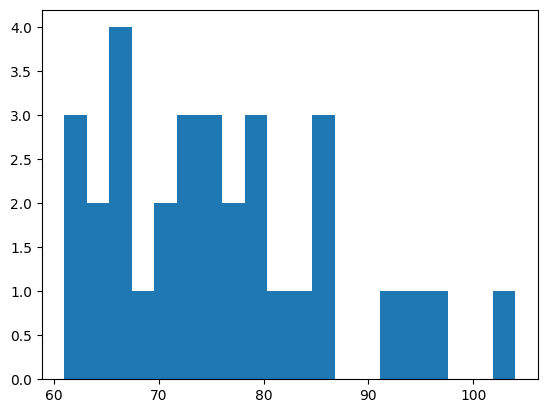

In [ ]:
# Visualizamos distribucion de sec segmentadas

plt.hist(length_doc, bins=20)

In [ ]:
# Vamos a setear la ventana de contexto en 60 palabras (se podria haber elegida otra alternativa como la media de longitud de los documentos)

#max_context_size=int(np.mean(length_doc))
max_context_size=60

print(f"La ventana de contexto a utilizar será: {max_context_size}")

La ventana de contexto a utilizar será: 60


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Instanciamos Tokenizador

tokenizer=Tokenizer()

tokenizer.fit_on_texts(segmented_sec)

# Tokeninizamos

tokenized_sec=tokenizer.texts_to_sequences(segmented_sec)

In [ ]:
# len(tokenized_sec)

In [ ]:
print("Secuencia de palabras de secuencia 1")
print("")
print(segmented_sec[0])
print("")
print("Secuencia de tokens de secuencia 1")
print("")
print(tokenized_sec[0])

Secuencia de palabras de secuencia 1

['los', 'vengadores', 'son', 'un', 'grupo', 'de', 'los', 'héroes', 'más', 'poderosos', 'del', 'planeta', 'unidos', 'para', 'enfrentar', 'amenazas', 'que', 'ningún', 'héroe', 'podría', 'enfrentar', 'solo', 'la', 'iniciativa', 'vengadores', 'fue', 'idea', 'de', 'nick', 'fury', 'director', 'de', 'shield', 'quien', 'reconoció', 'la', 'necesidad', 'de', 'un', 'equipo', 'formidable', 'para', 'proteger', 'al', 'mundo', 'de', 'peligros', 'extraordinarios', 'este', 'grupo', 'comenzó', 'a', 'formarse', 'cuando', 'loki', 'el', 'dios', 'nórdico', 'del', 'engaño', 'llegó', 'a', 'la', 'tierra', 'con', 'la', 'intención', 'de', 'conquistarla', 'usando', 'el', 'poder', 'del', 'teseracto', 'un', 'artefacto', 'cósmico', 'de', 'inmenso', 'poder']

Secuencia de tokens de secuencia 1

[4, 19, 46, 8, 76, 1, 4, 22, 23, 159, 10, 97, 278, 13, 77, 78, 11, 279, 160, 280, 77, 47, 2, 281, 19, 25, 282, 1, 283, 284, 285, 1, 286, 48, 287, 2, 161, 1, 8, 49, 162, 13, 79, 28, 35, 1, 

In [ ]:
# Diccionario token -> palabra
tokenizer.index_word

{1: 'de',
 2: 'la',
 3: 'y',
 4: 'los',
 5: 'el',
 6: 'en',
 7: 'a',
 8: 'un',
 9: 'su',
 10: 'del',
 11: 'que',
 12: 'con',
 13: 'para',
 14: 'por',
 15: 'thanos',
 16: 'una',
 17: 'sus',
 18: 'las',
 19: 'vengadores',
 20: 'como',
 21: 'x',
 22: 'héroes',
 23: 'más',
 24: 'men',
 25: 'fue',
 26: 'peter',
 27: 'universo',
 28: 'al',
 29: 'mutantes',
 30: 'lo',
 31: 'se',
 32: 'gemas',
 33: 'contra',
 34: 'gema',
 35: 'mundo',
 36: 'man',
 37: 'poder',
 38: 'batalla',
 39: 'infinito',
 40: 'es',
 41: 'lucha',
 42: 'hombre',
 43: 'esperanza',
 44: 'vida',
 45: 'spider',
 46: 'son',
 47: 'solo',
 48: 'quien',
 49: 'equipo',
 50: 'cada',
 51: 'habilidades',
 52: 'fuerza',
 53: 'donde',
 54: 'titán',
 55: 'marvel',
 56: 'siempre',
 57: 'mientras',
 58: 'uno',
 59: 'esta',
 60: 'futuro',
 61: 'este',
 62: 'nueva',
 63: 'han',
 64: 'visión',
 65: 'parker',
 66: 'saga',
 67: 'otros',
 68: 'sin',
 69: 'no',
 70: 'xavier',
 71: 'mutante',
 72: 'pesar',
 73: 'era',
 74: 'tiempo',
 75: 'guantelet

In [ ]:
# Diccionario palabra -> token
tokenizer.word_index

{'de': 1,
 'la': 2,
 'y': 3,
 'los': 4,
 'el': 5,
 'en': 6,
 'a': 7,
 'un': 8,
 'su': 9,
 'del': 10,
 'que': 11,
 'con': 12,
 'para': 13,
 'por': 14,
 'thanos': 15,
 'una': 16,
 'sus': 17,
 'las': 18,
 'vengadores': 19,
 'como': 20,
 'x': 21,
 'héroes': 22,
 'más': 23,
 'men': 24,
 'fue': 25,
 'peter': 26,
 'universo': 27,
 'al': 28,
 'mutantes': 29,
 'lo': 30,
 'se': 31,
 'gemas': 32,
 'contra': 33,
 'gema': 34,
 'mundo': 35,
 'man': 36,
 'poder': 37,
 'batalla': 38,
 'infinito': 39,
 'es': 40,
 'lucha': 41,
 'hombre': 42,
 'esperanza': 43,
 'vida': 44,
 'spider': 45,
 'son': 46,
 'solo': 47,
 'quien': 48,
 'equipo': 49,
 'cada': 50,
 'habilidades': 51,
 'fuerza': 52,
 'donde': 53,
 'titán': 54,
 'marvel': 55,
 'siempre': 56,
 'mientras': 57,
 'uno': 58,
 'esta': 59,
 'futuro': 60,
 'este': 61,
 'nueva': 62,
 'han': 63,
 'visión': 64,
 'parker': 65,
 'saga': 66,
 'otros': 67,
 'sin': 68,
 'no': 69,
 'xavier': 70,
 'mutante': 71,
 'pesar': 72,
 'era': 73,
 'tiempo': 74,
 'guantelete': 

In [ ]:
# cantidad de muestras de train
#len(tok_sec_train)

In [ ]:
# cantidad de muestras de test
#len(tok_sec_test)

Para aumentar los datos con los que trabajaremos haremos lo siguiente:
- La secuencias que superan el tamaño de contexto máximo vamos a splittearlas en secuencias del tamaño maximo de contexto.

In [ ]:
tok_sec=[]

for sec in tokenized_sec:
  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sec)>(max_context_size):
    extra=len(sec)-max_context_size
    for i in range(extra+1):
      tok_sec.append(sec[i:i+max_context_size])
  else: # Si la secuencia tiene tamaño max de contexto se mantiene igual
    tok_sec.append(sec)

# Visualizamos si aumentaron los datos de train

len(tok_sec)

545

In [ ]:
# Aumentación de dato en separación en secuencias mas cortas

"""from tensorflow.keras.utils import pad_sequences

tok_sec_aug=[]

max_subseq=50

for sec in tok_sec:
  for i in range(len(sec)-1):
    #for j in range(i+2,len(sec)+1):
     # subseq=sec[i:j] # Generaria no solo las subsecuencias aumentadas desde el inicio de la secuencia, sino también todas las posibles subsecuencias internas de la secuencia
      subseq = sec[i:i+max_subseq+1]
      tok_sec_aug.append(subseq)

tok_sec_aug_padded=pad_sequences(tok_sec_aug, maxlen=max_context_size+1, padding="post")"""

'from tensorflow.keras.utils import pad_sequences\n\ntok_sec_aug=[]\n\nmax_subseq=50\n\nfor sec in tok_sec:\n  for i in range(len(sec)-1):\n    #for j in range(i+2,len(sec)+1):\n     # subseq=sec[i:j] # Generaria no solo las subsecuencias aumentadas desde el inicio de la secuencia, sino también todas las posibles subsecuencias internas de la secuencia\n      subseq = sec[i:i+max_subseq+1]\n      tok_sec_aug.append(subseq)\n\ntok_sec_aug_padded=pad_sequences(tok_sec_aug, maxlen=max_context_size+1, padding="post")'

In [ ]:
# Alternativa de codigo a anterior

"""max_subseq_length = 20
tok_sec_aug = []

for sec in tok_sec:
    # Generar subsecuencias de máximo 20 caracteres
    for i in range(0, len(sec), max_subseq_length):
        subseq = sec[i:i + max_subseq_length]
        tok_sec_aug.append(subseq)
tok_sec_aug_padded = pad_sequences(tok_sec_aug, maxlen=max_context_size + 1, padding='post'"""

"max_subseq_length = 20\ntok_sec_aug = []\n\nfor sec in tok_sec:\n    # Generar subsecuencias de máximo 20 caracteres\n    for i in range(0, len(sec), max_subseq_length):\n        subseq = sec[i:i + max_subseq_length]\n        tok_sec_aug.append(subseq)\ntok_sec_aug_padded = pad_sequences(tok_sec_aug, maxlen=max_context_size + 1, padding='post'"

In [ ]:
tok_sec_train, tok_sec_val,_,_=train_test_split(tok_sec,tok_sec,test_size=0.3, random_state=74)

In [ ]:
from tensorflow.keras.utils import pad_sequences
tok_sec_aug_padded=pad_sequences(tok_sec_train, maxlen=max_context_size+1, padding="pre")

In [ ]:
tok_sec_aug_padded.shape

(381, 61)

In [ ]:
X_train=tok_sec_aug_padded[:,:-1]
y_train=tok_sec_aug_padded[:,1:]

In [ ]:
tok_sec_val_padded = pad_sequences(tok_sec_val, maxlen=max_context_size+1, padding='pre')

In [ ]:
X_val=tok_sec_val_padded[:,:-1]
y_val=tok_sec_val_padded[:,1:]

In [ ]:
X_train.shape

(381, 60)

In [ ]:
y_train.shape

(381, 60)

In [ ]:
X_val.shape

(164, 60)

In [ ]:
y_val.shape

(164, 60)

In [ ]:
# Tamamaño del vocabulario
vocab_size=len(tokenizer.word_counts)
vocab_size

851

In [ ]:
"""class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True"""

'class PplCallback(keras.callbacks.Callback):\n\n    \'\'\'\n    Este callback es una solución ad-hoc para calcular al final de cada epoch de\n    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.\n    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.\n    Además implementa la finalización del entrenamiento (Early Stopping)\n    si la perplejidad no mejora después de `patience` epochs.\n    \'\'\'\n\n    def __init__(self, val_data, history_ppl, patience=5):\n      # El callback lo inicializamos con secuencias de validación sobre las cuales\n      # mediremos la perplejidad y la paciencia para detener el entrenamiento.\n      self.val_data = val_data\n\n      self.target = []\n      self.padded = []\n\n      count = 0\n      self.info = []\n      self.history_ppl = []\n      self.min_score = np.inf\n      self.patience_counter = 0\n      self.patience = patience\n\n      # nos movemos en todas las secuenci

In [ ]:
# Model

from tensorflow.keras.regularizers import l2
from keras_nlp.metrics import Perplexity

model=Sequential()

model.add(Embedding(input_dim=vocab_size+1,output_dim=100, input_shape=(60,)))
model.add(GRU(250, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(LSTM(150,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(LSTM(100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(LSTM(50,return_sequences=True,kernel_regularizer=l2(1e-4)))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(vocab_size+1, activation='softmax',kernel_regularizer=l2(1e-4)))

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=[Perplexity()])

model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 60, 100)             │          85,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 60, 250)             │         264,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 60, 250)             │           1,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 60, 150)             │         240,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 60, 150)             │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 60, 100)             │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 60, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 60, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 60, 852)             │          43,452 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 766,052 (2.92 MB)

 Trainable params: 764,952 (2.92 MB)

 Non-trainable params: 1,100 (4.30 KB)

In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 6.7688 - perplexity: 851.4915 - val_loss: 6.7567 - val_perplexity: 840.7785
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 6.5333 - perplexity: 672.5822 - val_loss: 6.7473 - val_perplexity: 832.9771
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 935ms/step - loss: 6.3463 - perplexity: 557.9124 - val_loss: 6.7372 - val_perplexity: 824.5408
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 997ms/step - loss: 6.1670 - perplexity: 466.3265 - val_loss: 6.7287 - val_perplexity: 817.3938
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 5.9958 - perplexity: 392.8358 - val_loss: 6.7178 - val_perplexity: 808.3352
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 943ms/step - loss: 5.8387 - perplexity: 335.7686 - val_loss: 6.7059 - val_perplexity: 798.5488
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 933ms/step - loss: 5.6640 - perplexity: 281.7021 - val_loss: 6.6945 - val_perplexity: 789.1652
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 810ms/step - loss: 5.5061

In [ ]:
# Model_1

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model_1 = Sequential()

model_1.add(Embedding(input_dim=vocab_size + 1, output_dim=150, input_shape=(60,)))
model_1.add(GRU(250, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
model_1.add(BatchNormalization())
model_1.add(LSTM(150, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_1.add(BatchNormalization())
model_1.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_1.add(BatchNormalization())
model_1.add(Dense(100, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(vocab_size + 1, activation='softmax',kernel_regularizer=l2(1e-4)))
optimizer = Adam(learning_rate=0.001)
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[Perplexity()])
model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 60, 150)             │         127,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 60, 250)             │         301,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 60, 250)             │           1,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 60, 150)             │         240,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 60, 150)             │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 60, 100)             │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 60, 100)             │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 60, 852)             │          86,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 868,452 (3.31 MB)

 Trainable params: 867,452 (3.31 MB)

 Non-trainable params: 1,000 (3.91 KB)

In [ ]:
# Entrenar el modelo

hist = model_1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 6.7103 - perplexity: 808.4420 - val_loss: 6.7540 - val_perplexity: 842.1825
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 811ms/step - loss: 6.2382 - perplexity: 503.8792 - val_loss: 6.7350 - val_perplexity: 825.8830
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 5.7822 - perplexity: 319.2352 - val_loss: 6.7080 - val_perplexity: 803.0933
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 817ms/step - loss: 5.3178 - perplexity: 200.2757 - val_loss: 6.6707 - val_perplexity: 772.6215
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 4.9202 - perplexity: 134.4405 - val_loss: 6.6254 - val_perplexity: 737.1970
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 820ms/step - loss: 4.5239 - perplexity: 90.1584 - val_loss: 6.5713 - val_perplexity: 697.2170
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 4.2479 - perplexity: 68.3602 - val_loss: 6.5280 - val_perplexity: 666.4913
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 940ms/step - loss: 3.9531 - perplexi

In [ ]:
# model_2

model_2 = Sequential()

model_2.add(Embedding(input_dim=vocab_size + 1, output_dim=100, input_shape=(60,)))
model_2.add(GRU(250, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
model_2.add(Dense(vocab_size + 1, activation='softmax',kernel_regularizer=l2(1e-4)))
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=[Perplexity()])
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 60, 100)             │          85,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 60, 250)             │         264,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 60, 852)             │         213,852 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 563,052 (2.15 MB)

 Trainable params: 563,052 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 964ms/step - loss: 6.7774 - perplexity: 844.6652 - val_loss: 6.7506 - val_perplexity: 822.4819
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 604ms/step - loss: 6.7256 - perplexity: 802.3132 - val_loss: 6.5231 - val_perplexity: 655.1822
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 963ms/step - loss: 6.2752 - perplexity: 515.4671 - val_loss: 5.8903 - val_perplexity: 347.9972
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step - loss: 5.8229 - perplexity: 325.3188 - val_loss: 5.8367 - val_perplexity: 329.8295
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - loss: 5.7816 - perplexity: 312.1805 - val_loss: 5.8134 - val_perplexity: 322.2786
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 622ms/step - loss: 5.7578 - perplexity: 304.8667 - val_loss: 5.7923 - val_perplexity: 315.5959
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - loss: 5.7484 - perplexity: 302.0793 - val_loss: 5.7799 - val_perplexity: 311.7569
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 604ms/step - loss: 5.72

In [ ]:
history_dict=history.history
hist_dict=hist.history
hist2_dict=hist_2.history
val_perplexity_values_model = history_dict['val_perplexity']
val_perplexity_values_model_1 = hist_dict['val_perplexity']
val_perplexity_values_model_2 = hist2_dict['val_perplexity']
perplexity_values_model = history_dict['perplexity']
perplexity_values_model_1 = hist_dict['perplexity']
perplexity_values_model_2 = hist2_dict['perplexity']


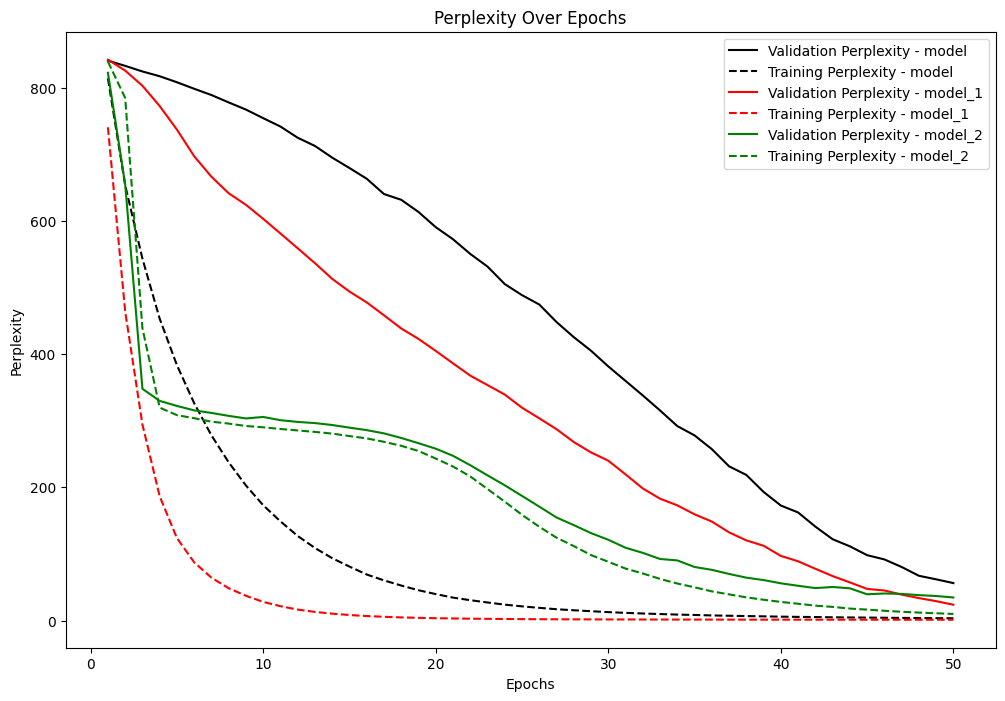

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))

epoch_count = range(1, len(val_perplexity_values_model) + 1)

sns.lineplot(x=epoch_count, y=val_perplexity_values_model, label='Validation Perplexity - model', linestyle='-', color='black')
sns.lineplot(x=epoch_count, y=perplexity_values_model, label='Training Perplexity - model', linestyle='--', color='black')
sns.lineplot(x=epoch_count, y=val_perplexity_values_model_1, label='Validation Perplexity - model_1', linestyle='-', color='r')
sns.lineplot(x=epoch_count, y=perplexity_values_model_1, label='Training Perplexity - model_1', linestyle='--', color='r')
sns.lineplot(x=epoch_count, y=val_perplexity_values_model_2, label='Validation Perplexity - model_2', linestyle='-', color='g')
sns.lineplot(x=epoch_count, y=perplexity_values_model_2, label='Training Perplexity - model_2', linestyle='--', color='g')

plt.title('Perplexity Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

plt.legend()

plt.show()

Podemos observar que todos modelos "ajustaron" bien ya que monitoreando la métrica de perplejidad.Los dos primeros en las poseen un overfitting claro, esto se debe seguramente a la profundidad de la red y la cantidad de parametros para procesar un corpus relativamente sencillo (851 palabras). El modelo 3 (model_2) al ser mas sencillo no overfitteo y la perplejidad tanto en train como valid disminuian parejas epoch a epoch.

Por lo anterior descriptó, usaremos para model_2 generar secuencias.

### Predicciones

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:
word_doc = tokenizer.word_docs

sorted_word_docs = sorted(word_doc.items(), key=lambda x: x[1], reverse=True)

sorted_word_docs


[('la', 32),
 ('de', 31),
 ('y', 31),
 ('a', 29),
 ('los', 27),
 ('el', 26),
 ('un', 26),
 ('en', 25),
 ('para', 22),
 ('del', 22),
 ('su', 22),
 ('que', 21),
 ('por', 21),
 ('con', 20),
 ('una', 16),
 ('sus', 14),
 ('las', 13),
 ('héroes', 12),
 ('más', 12),
 ('thanos', 12),
 ('fue', 11),
 ('como', 11),
 ('vengadores', 10),
 ('al', 10),
 ('mundo', 9),
 ('lo', 9),
 ('universo', 9),
 ('batalla', 8),
 ('peter', 8),
 ('se', 8),
 ('contra', 8),
 ('men', 8),
 ('x', 8),
 ('lucha', 8),
 ('hombre', 7),
 ('gemas', 7),
 ('poder', 6),
 ('quien', 6),
 ('solo', 6),
 ('equipo', 6),
 ('habilidades', 6),
 ('man', 6),
 ('donde', 6),
 ('titán', 6),
 ('esperanza', 6),
 ('marvel', 6),
 ('mientras', 6),
 ('mutantes', 6),
 ('es', 6),
 ('uno', 6),
 ('son', 5),
 ('este', 5),
 ('fuerza', 5),
 ('cada', 5),
 ('nueva', 5),
 ('infinito', 5),
 ('sin', 5),
 ('siempre', 5),
 ('no', 5),
 ('esta', 5),
 ('pesar', 5),
 ('vida', 5),
 ('spider', 5),
 ('tiempo', 5),
 ('amenazas', 4),
 ('tierra', 4),
 ('dios', 4),
 ('protege

In [ ]:
input_text='Los X '

generate_seq(model_2, tokenizer, input_text, max_length=max_context_size, n_words=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


'Los X  men han enfrentado'

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tokenizer.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tokenizer.sequences_to_texts([seq])

Beam search y muestreo aleatorio

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
salidas = beam_search(model,num_beams=10,num_words=3,input="Los X ",temp=1.5,mode='det')

In [ ]:
salidas.shape

(10, 63)

In [ ]:
decode(salidas[0])

['los x podían sus sus']

In [ ]:
salidas = beam_search(model,num_beams=10,num_words=3,input="Los X ",temp=0.5,mode='sto')

In [ ]:
salidas.shape

(10, 63)

In [ ]:
decode(salidas[0])

['los x son puedan equipo']

**Conclusión**:

Los resultados en la generación de secuencias son pobres y el gran desafío radica en el tamaño limitado y la diversidad del corpus utilizado para entrenar el modelo. A diferencia de otros modelos que se benefician de grandes y diversos conjuntos de datos, mi modelo se ha entrenado con un corpus más pequeño y menos variado. Esto ha impactado la capacidad del modelo para capturar y generalizar patrones complejos en el lenguaje.

Además, las limitaciones técnicas del modelo, como la arquitectura y los parámetros seleccionados, han influido en su desempeño. Aunque se han implementado técnicas como regularización y optimización del aprendizaje, la complejidad inherente del lenguaje natural y las limitaciones de recursos han impuesto restricciones claras.


## Modelo de lenguaje con tokenización por caracter

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


Tamaño de contexto:

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus de texto puede ser considerado un documento en sí mismo y el tamaño de contexto puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados

In [ ]:
# Seteo de tamaño de contexto maximo

max_context_size=50

In [ ]:
with open('combined_text.txt', 'r', encoding='utf-8') as file:
    text = file.read().lower()


In [ ]:
text

'los vengadores son un grupo de los héroes más poderosos del planeta, unidos para enfrentar amenazas que ningún héroe podría enfrentar solo. la iniciativa vengadores fue idea de nick fury, director de shield., quien reconoció la necesidad de un equipo formidable para proteger al mundo de peligros extraordinarios. este grupo comenzó a formarse cuando loki, el dios nórdico del engaño, llegó a la tierra con la intención de conquistarla usando el poder del teseracto, un artefacto cósmico de inmenso poder.\n\nla primera alineación de los vengadores incluyó a iron man (tony stark), capitán américa (steve rogers), thor, hulk (bruce banner), viuda negra (natasha romanoff) y ojo de halcón (clint barton). cada miembro trajo sus habilidades únicas al equipo: tony stark, con su intelecto brillante y su avanzada armadura tecnológica; steve rogers, con su liderazgo y su fuerza sobrehumana otorgada por el suero del súper soldado; thor, el poderoso dios del trueno con su martillo encantado, mjolnir; b

In [ ]:
tok = Tokenizer(char_level=True)
tok.fit_on_texts([text])




In [ ]:
# Vocabulario

vocab=set(text)

In [ ]:
vocab

{'\n',
 ' ',
 '"',
 '(',
 ')',
 ',',
 '-',
 '.',
 ':',
 ';',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'á',
 'é',
 'í',
 'ñ',
 'ó',
 'ú'}

In [ ]:
# Longitud de Vocabulario
vocab_size= len(vocab) +1 # para indice 0

print(f"El temaño del vocabulario es {vocab_size}")

El temaño del vocabulario es 43


In [ ]:
# Diccionario char --> numero
tok.word_index # Podemos ver que el indice 0 se encuentra reservado para caracter desconocido

{' ': 1,
 'e': 2,
 'a': 3,
 'o': 4,
 'n': 5,
 's': 6,
 'r': 7,
 'i': 8,
 'd': 9,
 'l': 10,
 't': 11,
 'u': 12,
 'c': 13,
 'm': 14,
 'p': 15,
 ',': 16,
 'v': 17,
 'g': 18,
 'b': 19,
 'h': 20,
 'f': 21,
 'y': 22,
 '.': 23,
 'ó': 24,
 'q': 25,
 '\n': 26,
 'á': 27,
 'z': 28,
 'x': 29,
 'í': 30,
 'é': 31,
 'j': 32,
 'k': 33,
 'ú': 34,
 '(': 35,
 ')': 36,
 'ñ': 37,
 'w': 38,
 '"': 39,
 ';': 40,
 ':': 41,
 '-': 42}

In [ ]:
char2idx = {k: v for v,k in enumerate(vocab)} # otra forma de conseguir dicc
                                              # usa otro orden y arranco en 0

In [ ]:
# char2idx

{'x': 0,
 'g': 1,
 'p': 2,
 'z': 3,
 ':': 4,
 'á': 5,
 'w': 6,
 '(': 7,
 'r': 8,
 'q': 9,
 'o': 10,
 '-': 11,
 'u': 12,
 'v': 13,
 ' ': 14,
 'i': 15,
 'c': 16,
 'h': 17,
 '.': 18,
 'n': 19,
 ';': 20,
 'd': 21,
 'j': 22,
 's': 23,
 'a': 24,
 't': 25,
 'ú': 26,
 'b': 27,
 'ó': 28,
 'ñ': 29,
 '"': 30,
 ')': 31,
 '\n': 32,
 'f': 33,
 ',': 34,
 'l': 35,
 'm': 36,
 'e': 37,
 'í': 38,
 'é': 39,
 'k': 40,
 'y': 41}

In [ ]:
# Diccionario  numero --> char
tok.index_word # Podemos ver que el indice 0 se encuentra reservado para caracter desconocido

{1: ' ',
 2: 'e',
 3: 'a',
 4: 'o',
 5: 'n',
 6: 's',
 7: 'r',
 8: 'i',
 9: 'd',
 10: 'l',
 11: 't',
 12: 'u',
 13: 'c',
 14: 'm',
 15: 'p',
 16: ',',
 17: 'v',
 18: 'g',
 19: 'b',
 20: 'h',
 21: 'f',
 22: 'y',
 23: '.',
 24: 'ó',
 25: 'q',
 26: '\n',
 27: 'á',
 28: 'z',
 29: 'x',
 30: 'í',
 31: 'é',
 32: 'j',
 33: 'k',
 34: 'ú',
 35: '(',
 36: ')',
 37: 'ñ',
 38: 'w',
 39: '"',
 40: ';',
 41: ':',
 42: '-'}

In [ ]:
idx2char = {v: k for k,v in char2idx.items()} # otra forma de conseguir dicc
                                              # usa otro orden y arranco en 0

In [ ]:
# idx2char

{0: 'x',
 1: 'g',
 2: 'p',
 3: 'z',
 4: ':',
 5: 'á',
 6: 'w',
 7: '(',
 8: 'r',
 9: 'q',
 10: 'o',
 11: '-',
 12: 'u',
 13: 'v',
 14: ' ',
 15: 'i',
 16: 'c',
 17: 'h',
 18: '.',
 19: 'n',
 20: ';',
 21: 'd',
 22: 'j',
 23: 's',
 24: 'a',
 25: 't',
 26: 'ú',
 27: 'b',
 28: 'ó',
 29: 'ñ',
 30: '"',
 31: ')',
 32: '\n',
 33: 'f',
 34: ',',
 35: 'l',
 36: 'm',
 37: 'e',
 38: 'í',
 39: 'é',
 40: 'k',
 41: 'y'}

In [ ]:
# Tokenizamos texto
# sequences = tok.texts_to_sequences([text])[0]
tokenized_text = [char2idx[ch] for ch in text]

In [ ]:
# Texto expresado como secuencia de tokens
# sequences
tokenized_text

[35,
 10,
 23,
 14,
 13,
 37,
 19,
 1,
 24,
 21,
 10,
 8,
 37,
 23,
 14,
 23,
 10,
 19,
 14,
 12,
 19,
 14,
 1,
 8,
 12,
 2,
 10,
 14,
 21,
 37,
 14,
 35,
 10,
 23,
 14,
 17,
 39,
 8,
 10,
 37,
 23,
 14,
 36,
 5,
 23,
 14,
 2,
 10,
 21,
 37,
 8,
 10,
 23,
 10,
 23,
 14,
 21,
 37,
 35,
 14,
 2,
 35,
 24,
 19,
 37,
 25,
 24,
 34,
 14,
 12,
 19,
 15,
 21,
 10,
 23,
 14,
 2,
 24,
 8,
 24,
 14,
 37,
 19,
 33,
 8,
 37,
 19,
 25,
 24,
 8,
 14,
 24,
 36,
 37,
 19,
 24,
 3,
 24,
 23,
 14,
 9,
 12,
 37,
 14,
 19,
 15,
 19,
 1,
 26,
 19,
 14,
 17,
 39,
 8,
 10,
 37,
 14,
 2,
 10,
 21,
 8,
 38,
 24,
 14,
 37,
 19,
 33,
 8,
 37,
 19,
 25,
 24,
 8,
 14,
 23,
 10,
 35,
 10,
 18,
 14,
 35,
 24,
 14,
 15,
 19,
 15,
 16,
 15,
 24,
 25,
 15,
 13,
 24,
 14,
 13,
 37,
 19,
 1,
 24,
 21,
 10,
 8,
 37,
 23,
 14,
 33,
 12,
 37,
 14,
 15,
 21,
 37,
 24,
 14,
 21,
 37,
 14,
 19,
 15,
 16,
 40,
 14,
 33,
 12,
 8,
 41,
 34,
 14,
 21,
 15,
 8,
 37,
 16,
 25,
 10,
 8,
 14,
 21,
 37,
 14,
 23,
 17,
 15,
 37,
 35,
 2

In [ ]:
# Longitud de corpus en caracteres
# len(sequences)
len(tokenized_text)

14976

In [ ]:
# type(sequences)
type(tokenized_text)

list

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parámetros
p_val = 0.3

# Calcula el número de secuencias de validación
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

# Divide el texto tokenizado en partes de entrenamiento y validación
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]



In [ ]:
X_train_char = np.array(tokenized_sentences_train[:-1])
y_train_char = np.array(tokenized_sentences_train[1:])


In [ ]:
X_train_char[1]

array([10, 23, 14, 13, 37, 19,  1, 24, 21, 10,  8, 37, 23, 14, 23, 10, 19,
       14, 12, 19, 14,  1,  8, 12,  2, 10, 14, 21, 37, 14, 35, 10, 23, 14,
       17, 39,  8, 10, 37, 23, 14, 36,  5, 23, 14,  2, 10, 21, 37,  8, 10,
       23, 10, 23, 14, 21, 37, 35, 14,  2, 35, 24, 19, 37, 25, 24, 34, 14,
       12, 19, 15, 21, 10, 23, 14,  2, 24,  8, 24, 14, 37, 19, 33,  8, 37,
       19, 25, 24,  8, 14, 24, 36, 37, 19, 24,  3, 24, 23, 14,  9])

In [ ]:
y_train_char[1]

array([23, 14, 13, 37, 19,  1, 24, 21, 10,  8, 37, 23, 14, 23, 10, 19, 14,
       12, 19, 14,  1,  8, 12,  2, 10, 14, 21, 37, 14, 35, 10, 23, 14, 17,
       39,  8, 10, 37, 23, 14, 36,  5, 23, 14,  2, 10, 21, 37,  8, 10, 23,
       10, 23, 14, 21, 37, 35, 14,  2, 35, 24, 19, 37, 25, 24, 34, 14, 12,
       19, 15, 21, 10, 23, 14,  2, 24,  8, 24, 14, 37, 19, 33,  8, 37, 19,
       25, 24,  8, 14, 24, 36, 37, 19, 24,  3, 24, 23, 14,  9, 12])

In [ ]:
decoded_sequence = ''.join([idx2char[idx] for idx in X_train_char[1]])

print(decoded_sequence)

print("")

decoded_sequence = ''.join([idx2char[idx] for idx in y_train_char[1]])

print(decoded_sequence)

os vengadores son un grupo de los héroes más poderosos del planeta, unidos para enfrentar amenazas q

s vengadores son un grupo de los héroes más poderosos del planeta, unidos para enfrentar amenazas qu


In [ ]:
X_train_char.shape

(10376, 100)

In [ ]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN
from keras.models import Model
from keras_nlp.metrics import Perplexity

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [ ]:
model_char = Sequential()

model_char.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_char.add(GRU(50, return_sequences=True ))
model_char.add(Dense(vocab_size, activation='softmax'))
model_char.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=[Perplexity()])

model_char.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_9 (TimeDistributed) │ (None, None, 43)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, None, 50)            │          14,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, None, 43)            │           2,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,443 (64.23 KB)

 Trainable params: 16,443 (64.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_ppl = []
history_char = model_char.fit(X_train_char, y_train_char, epochs=10, batch_size=128, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)])

Epoch 1/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.3811 - perplexity: 30.0541
 mean perplexity: 18.014752932302308 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - loss: 3.3751 - perplexity: 29.8840
Epoch 2/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.8583 - perplexity: 17.4415
 mean perplexity: 14.301061618248305 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 2.8568 - perplexity: 17.4162
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.5994 - perplexity: 13.4637
 mean perplexity: 11.911708380811861 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - loss: 2.5988 - perplexity: 13.4552
Epoch 4/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.4138 - perplexity: 11.1786
 mean perplexity: 10.66690234024074 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - loss: 2.4129 - perplexity: 11.1690
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.2867 - perplexity: 9.8435
 mean perplexity:

In [ ]:
# model_char_2

model_char_2 = Sequential()

model_char_2.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_char_2.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_char_2.add(Dense(vocab_size, activation='softmax'))
model_char_2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=[Perplexity()])

model_char_2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_10                  │ (None, None, 43)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 100)           │          57,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, None, 43)            │           4,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,943 (241.96 KB)

 Trainable params: 61,943 (241.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_ppl_2 = []
history_char_2 = model_char_2.fit(X_train_char, y_train_char, epochs=10, batch_size=128, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_2)])

Epoch 1/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 3.2122 - perplexity: 25.3403
 mean perplexity: 18.858077603307343 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 66s 332ms/step - loss: 3.2084 - perplexity: 25.2403
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 2.9259 - perplexity: 18.6535
 mean perplexity: 16.640314404198183 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - loss: 2.9255 - perplexity: 18.6465
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 2.7792 - perplexity: 16.1116
 mean perplexity: 14.28731325725296 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - loss: 2.7787 - perplexity: 16.1036
Epoch 4/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 2.6234 - perplexity: 13.7855
 mean perplexity: 12.596867048571259 

Saved new model!
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 265ms/step - loss: 2.6227 - perplexity: 13.7755
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 2.5099 - perplexity: 12.3045
 mean perplexity

In [ ]:
history_dict_char=history_char.history
history_dict_char_2=history_char_2.history
history_dict_char_3=history_char_3.history
perplexity_values_model_char = history_dict_char['perplexity']
perplexity_values_model_char_2 = history_dict_char_2['perplexity']
perplexity_values_model_char_3 = history_dict_char_3['perplexity']

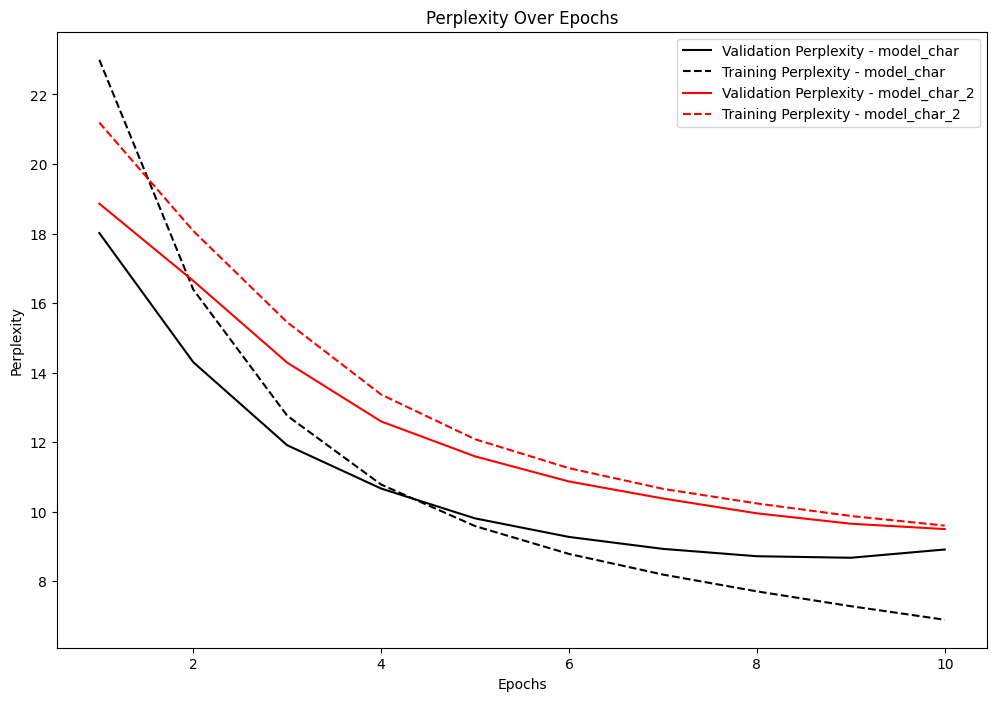

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))

epoch_count = range(1, len(perplexity_values_model_char) + 1)

sns.lineplot(x=epoch_count, y=history_ppl[0:10], label='Validation Perplexity - model_char', linestyle='-', color='black')
sns.lineplot(x=epoch_count, y=perplexity_values_model_char, label='Training Perplexity - model_char', linestyle='--', color='black')
sns.lineplot(x=epoch_count, y=history_ppl[10:20], label='Validation Perplexity - model_char_2', linestyle='-', color='r')
sns.lineplot(x=epoch_count, y=perplexity_values_model_char_2, label='Training Perplexity - model_char_2', linestyle='--', color='r')

plt.title('Perplexity Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

plt.legend()

plt.show()

Puede ver que el modelo 1 sobreajuste un poco. En cambio, el modelo 2 no se observa un overfitting.

En ambos modelos parace que el entrenamiento aun no se ha estabilizado por lo que podría seguir entrenandose algunas epochs mas.

Usaremos ambos modelos para predecir y generar secuencias.

### Predicciones

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:
input_text='La Saga del '

generate_seq(model_char, input_text, max_length=max_context_size, n_words=10)

'La Saga del su por en '

In [ ]:
input_text='Los Saga del '

generate_seq(model_char_2, input_text, max_length=max_context_size, n_words=10)

'Los Saga del enteres en'

Beem Search y muestreo aleatorio

In [ ]:
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
# predicción con beam search
output = beam_search(model_char,num_beams=10,num_words=10,input="la saga del",temp=1.5)

In [ ]:
output[0]

array([35, 24, 14, 23, 24,  1, 24, 14, 21, 37, 35, 37, 23, 14, 21, 37, 14,
       35, 10, 23, 14])

In [ ]:
decode(output[0])

'la saga deles de los '

In [ ]:
# predicción con beam search
output = beam_search(model_char_2,num_beams=10,num_words=10,input="la saga del",temp=0.5)

In [ ]:
output[0]

array([35, 24, 14, 23, 24,  1, 24, 14, 21, 37, 35, 14, 21, 37, 23, 14, 37,
       19, 25, 37,  8])

In [ ]:
decode(output[0])

'la saga del des enter'

**Conclusión**:

Los resultados en la generación de modelos de lenguaje a nivel caracter no muestran mejoras significativas en comparación con los modelos a nivel palabra. Esta tarea resulta aún más compleja porque el modelo debe aprender a reconocer qué combinaciones de caracteres forman palabras y cuáles no tienen sentido alguno. Además, debe aprender cuándo insertar espacios, comas o puntos para formar texto coherente.

Dado que el corpus con el que se entrenó el modelo era pequeño y carecía de variabilidad semántica, resulta prácticamente imposible que el modelo pueda capturar estas complejidades.